## Imports and configuration

In [4]:
import os, re, requests, time, tldextract
import numpy as np
import pandas as pd
import seaborn as sns
import wikipedia as wp
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from scipy import stats
from tqdm import tqdm

# Configuring matplotlib to output opaque images
import matplotlib as mpl
mpl.rcParams["savefig.facecolor"] = "w"

# We do only read operations, therefore no user config is necessary.
# Normally the system crashes when there is no user config unless we tell it otherwise with this environment variable.
#   0 is default
#   1 means ignore the config
#   2 means ignore the config and don't throw warnings
os.environ["PYWIKIBOT_NO_USER_CONFIG"] = "2"

# Now we can import pywikibot
import pywikibot as pwb
import pywikibot.data.api as api

# Then we can setup references for Wikipedia and Wikidata
wiki_site = pwb.Site(code="en", fam="wikipedia")
data_site = pwb.Site(code="wikidata", fam="wikidata")
repo = data_site.data_repository()

# Setting important dates
stime = "2015070100"
etime = str(datetime.today().date()).replace("-", "") + "00"

# We list here the search terms for EPFL
epfl_alts = [
    "EPFL",
    "École Polytechnique Fédérale de Lausanne",
    "Swiss Federal Institute of Technology",
    "EPF Lausanne",
    "ETH Lausanne",
    "Poly Lausanne",
]

# Setting paths
im_path = "graphs"

Let's generate a list of all the pages that mention EPFL. We set `namespace=0` as this namespace is the one that contains regular pages. Note that searches from Pywikibot are ordered alphabetically by default, unlike what the Wikipedia API does.

In [22]:
def save_pagenames(pnames):
    with open("pagenames.txt", "w", encoding="utf-8") as f:
        f.write("\n".join(pnames), )
        
def load_pagenames():
    try:
        with open("pagenames.txt", "r", encoding="utf-8") as f:
            return f.read().split("\n")
    except:
        return []

def collect_pages(site, keywords):
    # Search for each keyword
    searches = [site.search(kw.lower(), where="text", namespaces=0) for kw in keywords]
    
    # Get the pages and flatten
    pages_raw = [list(s) for s in searches]
    pages = list(set([item for sublist in pages_raw for item in sublist]))
    ret = []
    old_names = load_pagenames()
    ignored = []
    
    # We filter out pages that do not have a WikiData item
    for p in tqdm(pages):
        try:
            if p.title() not in old_names:
                x = p.data_item()
        except:
            ignored.append(p.title())
            continue

        ret.append(p)
    
    new_pnames = list(set(old_names + [p.title() for p in ret]))
    save_pagenames(new_pnames)
    print(ignored)
    return ret

In [23]:
epfl_pages = collect_pages(wiki_site, epfl_alts)
print(len(epfl_pages), "pages currently tracked.")

100%|█████████████████████████████████████████████████████████████████████████████| 5033/5033 [00:34<00:00, 144.17it/s]

['Privacy concerns of Facebook', 'Evidence and efficacy of homeopathy', 'Johannes Gräff', 'Gender parity', 'March 1921', 'July–September 2020 in science', 'Jacques Fellay', 'Pierre Gönczy', 'Fish for finance', 'League of entropy', 'Two-Mona Lisa theory', 'Zero Trust Networks', 'Joël Mesot', 'Social class in the United States', 'List of German abbreviations', 'Financial Review Rich List 2020', 'List of organizations nominated for the Nobel Peace Prize']
5016 pages currently tracked.


It is important to note that Wikipedia started storing page view statistics since July 1st, 2015. This means we will not have any data available before that time.

## Accessing a page

Let's look at the different ways we can refer to a given page. We will be using Martin Vetterli's page for our examples.

In [117]:
# We can get a page by name
page = pwb.Page(wiki_site, u"Martin Vetterli")
page

Page('Martin Vetterli')

In [8]:
# We can get its data reference
item = page.data_item()
item

ItemPage('Q6776811')

In [9]:
# We can get the reference directly
item = pwb.ItemPage(repo, "Q6776811")
item

ItemPage('Q6776811')

In [10]:
# And we can get all the pages linked to this reference through WikiData
for k, v in dict(item.sitelinks).items():
    print(k + "\n\t" + v.ns_title())

commonswiki
	Category:Martin Vetterli
dewiki
	Martin Vetterli
enwiki
	Martin Vetterli
frwiki
	Martin Vetterli
frwikiquote
	Martin Vetterli


## Mentions of EPFL in a page

In [11]:
def pagecounts(page, strings):
    return [page.text.count(s) for s in strings]

In [12]:
pcs = pagecounts(page, epfl_alts)
pcs

[12, 6, 0, 0, 0, 0]

In [13]:
req = api.Request(site=data_site, parameters={'action': 'query',
                                                'titles': item,
                                                'prop': 'pageviews',
                                                'pvipdays': 1000})

print("As the warning above says, the default API request gives us a maximum of", len(req.submit()['query']['pages'][str(item.pageid)]['pageviews']), "days of data. This is insufficient.")

As the warning above says, the default API request gives us a maximum of 60 days of data. This is insufficient.


In [14]:
# Set dates
pp_first = datetime.strptime(stime, "%Y%m%d00").strftime("%B %d, %Y").replace(" 0", " ")
pp_today = datetime.today().strftime("%B %d, %Y").replace(" 0", " ")

# Request data
page_name = "Martin_Vetterli"
pv_url = "https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/all-agents/%s/daily/%s/%s"
r = requests.get(pv_url % (page_name, stime, etime))
print("Digging deeper into the API, we see we have access to", len(r.json()['items']), "days of pageview data since", pp_first, "as of", pp_today + ".")

Digging deeper into the API, we see we have access to 2002 days of pageview data since July 1, 2015 as of December 24, 2020.


## Mentions over time

For `getPageChanges`, we recover all revisions at once at it is significantly faster to do that than to call `page.getOldVersion` continuously.

It is important to note that our process is simplified to improve performance by minimizing the number of revisions requested; if a page had 5 mentions in 2008, 5 in 2010, but 4 in 2009, the 4 will be glossed over as we assume the amount of such cases will be rare and insignificant.

Getting the revisions without the content is approximately 7 times faster on large pages (35 vs. 5 seconds), while getting the text from the revisions or from `getOldVersion` takes the same amount of time. However we are still getting faster results for revisions with content when it is part of our functions.

In [15]:
def getCounts(revs, strings, idx):
    page = revs[idx]
    return sum([page.text.count(s) for s in strings])

def getOrUpdate(revs, strings, counts, idx, changes):
    if idx not in counts:
        temp = getCounts(revs, strings, idx)
        counts[idx] = temp
        
        # Do not consider the count if an earlier revision had more
        if not any([counts[k] > temp for k in counts.keys() if k < idx]):
            changes[temp] = min(changes.get(temp) or idx, idx) 
    
    return counts[idx]

def getMentions(page, strings):
    if not getCounts([page], strings, 0):
        return None
    
    cnt = page.revision_count()
    revs = list(page.revisions(reverse=True, content=True))

    # Start with whole scope
    queue = [(0, cnt - 1)]
    
    # To avoid double checking revisions we store the counts here
    cnts = {}
    
    # And here we store the count-index pairs
    changes = {}

    while queue:
        # Process first element
        r0, r1 = queue[0]
        queue = queue[1:]

        # Only proceed if current scope covers multiple indices
        if r0 != r1:
            # Get counts for both indices
            v0 = getOrUpdate(revs, strings, cnts, r0, changes)
            v1 = getOrUpdate(revs, strings, cnts, r1, changes)

            # Only proceed if there is a change of count in the current scope
            if v0 != v1 and abs(r1 - r0) > 1:
                mid = (r0 + r1) // 2
                queue.extend([(r0, mid), (mid, r1)])

    changes = {revs[v]["timestamp"]: k for k, v in changes.items()}
    changes = {datetime.combine(k.date(), k.time()): v for k, v in changes.items()}
    
    # Here we simplify our data to a maximum of one point per day (we take the last one)
    changes = pd.Series(changes, name="Mentions").sort_index().groupby(pd.Grouper(freq="1D")).nth(-1)
    return changes

In [16]:
pms = getMentions(page, epfl_alts)
pms

2007-08-08     5
2013-10-23     6
2014-02-13    11
2016-02-26    12
2017-01-01    15
2017-04-02    18
Name: Mentions, dtype: int64

<AxesSubplot:>

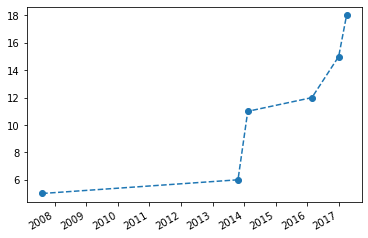

In [17]:
pms.plot(linestyle='--', marker='o')

## Views of a page over time

Here we compute the pageviews for each day and highlight the outliers.
In the future we will compute outliers based on the local average.

In [18]:
def pageviews(page, stime, etime):
    req = requests.get(pv_url % (page.title(), stime, etime))
    serie = pd.Series({datetime.strptime(str(item['timestamp'])[:-2], "%Y%m%d"): item['views'] for item in req.json()['items']}, name="Views")
    return serie

def outliers(serie):
    return pd.Series(serie[np.abs(stats.zscore(serie)) > 3], name="Outliers")

In [19]:
pvs = pageviews(page, stime, etime)
pvs

2015-07-01    11
2015-07-02    13
2015-07-03     5
2015-07-04     4
2015-07-05     8
              ..
2020-12-18    34
2020-12-19    16
2020-12-20    43
2020-12-21    28
2020-12-22    19
Name: Views, Length: 2002, dtype: int64

In [20]:
ols = outliers(pvs)
ols

2016-02-24    1233
2016-02-25     362
2016-02-26     135
2019-12-05     233
2019-12-06     469
2020-02-12     126
Name: Outliers, dtype: int64

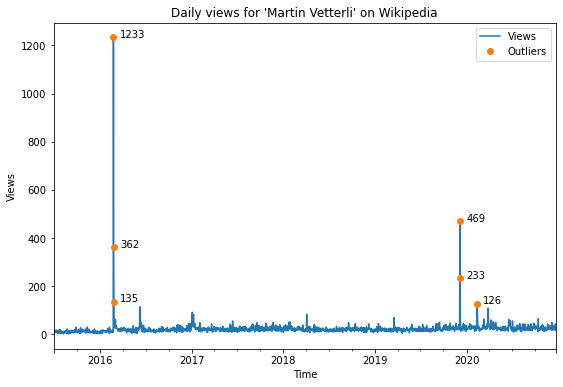

In [851]:
ax = pvs.plot(legend=True, title="Daily views for 'Martin Vetterli' on Wikipedia")
ax = ols.plot(legend=True, ax=ax, linestyle="", marker="o")
ax.set_xlabel('Time')
ax.set_ylabel('Views')
ax.figure.set_size_inches((9, 6))

for i, each in enumerate(ols.index):
    y = ols[each]
    ax.text(each + timedelta(25), y, y)
    
ax.figure.savefig(os.path.join(im_path, "views.png"))

With that out of the way, let's generate a list of all the pages that mention EPFL. We set `namespace=0` as this namespace is the one that contains regular pages. Note that searches from Pywikibot are ordered alphabetically by default, unlike what the Wikipedia API does.

In [644]:
pvs2 = pageviews(page, stime, etime)
to_rem = ols.index
pvs2[to_rem] = 0

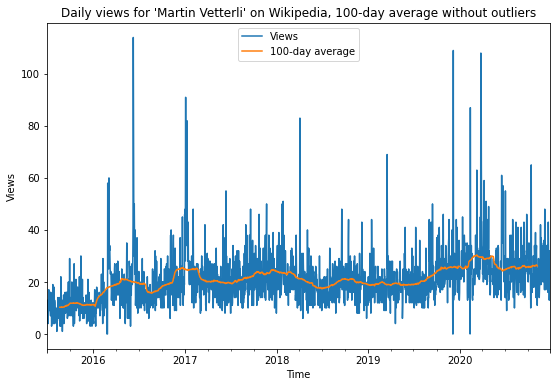

In [651]:
# Would be good to cover the whole dataset

v = 100
ax = pvs2.plot(legend=True)
(pvs2.rolling(v, center=True).sum() / v).plot(ax=ax, legend=True, label="100-day average", title="Daily views for 'Martin Vetterli' on Wikipedia, 100-day average without outliers")
ax.set_xlabel('Time')
ax.set_ylabel('Views')
ax.figure.set_size_inches((9, 6))
    
ax.figure.savefig(os.path.join(im_path, "views__avg.png"))

## Backlinks

So far I haven't found an efficient way to account for backlinks in page revisions. Therefore this will be skipped for now.

## Edits

In [903]:
def getPageSize(page):
    revs = list(page.revisions(reverse=True))
    df = pd.DataFrame([dict(r) for r in revs])
    df = df[["userid", "timestamp", "size", "minor"]]
    df = df.set_index("timestamp")
    
    # Get absolute size from relative size
    df["diff"] = (df['size'] - df['size'].shift(1)).abs()
    df["diff"] = df["diff"].fillna(df["size"])
    
    # Sample every month and shift by 1 day to get 1st of month
    df = df["size"].groupby(pd.Grouper(freq="1M")).nth(-1).resample("1M").pad()
    df.index = df.index.shift(1, freq="D")
    
    return df.rename(page.data_item().title())

In [904]:
psz = getPageSize(page)
psz

timestamp
2007-09-01     1441
2007-10-01     1439
2007-11-01     1439
2007-12-01     1439
2008-01-01     1439
              ...  
2020-09-01    11896
2020-10-01    11895
2020-11-01    11895
2020-12-01    11843
2021-01-01    11843
Name: Q6776811, Length: 161, dtype: int64

<AxesSubplot:xlabel='timestamp'>

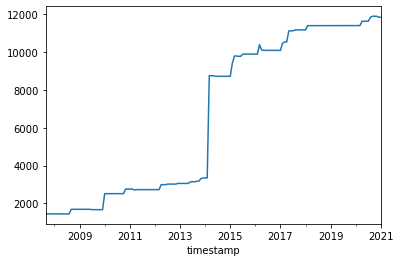

In [905]:
psz.plot()

In [26]:
def getPageScore(page):
    # Get mentions
    pms = getMentions(page, epfl_alts)
    
    if pms is None:
        return None
    
    # Get page views
    pvs = pageviews(page, stime, etime)
    
    # Get page size
    psz = getPageSize(page)
    
    # Combine the data
    df = pd.concat([pvs, psz.reindex(pvs.index), pms.reindex(pvs.index)], axis=1)
    df = df.ffill(axis=0)
    
    s_prev = psz.index.difference(pvs.index)
    s_fill = psz[s_prev[-1]] if len(s_prev) else 0
    df["Size"] = df["Size"].fillna(s_fill)
    
    m_prev = pms.index.difference(pvs.index)
    m_fill = pms[m_prev[-1]] if len(m_prev) else 0
    df["Mentions"] = df["Mentions"].fillna(m_fill)
    
    # Generate score
    df["Score"] = df["Mentions"] * df["Views"] / df["Size"]
    
    return df

In [27]:
psc = getPageScore(page)
psc

,Views,Size,Mentions,Score
2015-07-01,11,9894.0,11.0,0.012230
2015-07-02,13,9894.0,11.0,0.014453
2015-07-03,5,9894.0,11.0,0.005559
2015-07-04,4,9894.0,11.0,0.004447
2015-07-05,8,9894.0,11.0,0.008894
...,...,...,...,...
2020-12-18,34,11843.0,18.0,0.051676
2020-12-19,16,11843.0,18.0,0.024318
2020-12-20,43,11843.0,18.0,0.065355
2020-12-21,28,11843.0,18.0,0.042557


<AxesSubplot:>

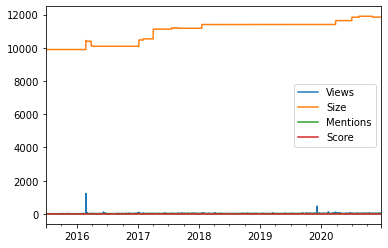

In [28]:
psc.plot()

## Editors

We will consider a user that changed their name as a new user for simplicity's sake.  
We do not use the function `page.contributors()` as it makes no distinction between regular and minor edits, and since we're going through the revisions we might as well extract that information in the process.

This can be improved by weighing the edits depending on the size increase of the page.

In [160]:
revs = list(page.revisions(reverse=True, content=True))

In [288]:
# Regular expressions to detect IP addresses and Bots.
pat_ip = re.compile('^\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}$|([0-9a-fA-F][0-9a-fA-F]{0,3}:){7}([0-9a-fA-F][0-9a-fA-F]{0,3}){1}')
pat_bot = re.compile(r'bot\b', re.IGNORECASE)

# Classify a user by its name into bots, real users, and IPs (unregistered users)
def classify_user(name):
    if pat_ip.match(name):
        return "IP"
    elif pat_bot.search(name):
        return "Bot"
    else:
        return "Real"

# Get user edit data from a page
def users(revs):
    # Get usernames and edit type
    df = pd.DataFrame([(r["user"], r["minor"]) for r in revs])
    
    # Set as index and sort 
    df.index = pd.MultiIndex.from_frame(df)
    df = df[[1]].sort_index(axis=0)
    
    # Group by user and edit type and split into columns
    df = pd.DataFrame(df.groupby(level=[0,1]).size())
    df = df.unstack(level=1, fill_value=0)
    
    # Rename columns and drop useless levels
    df = df.droplevel(level=0, axis=1)
    df.index.name = "Usernames"
    df.columns = ["Major", "Minor"]
    
    # Add user types as first index level
    df.index = pd.MultiIndex.from_tuples([classify_user(i), i] for i in df.index)
    
    return df.sort_index(axis=0)

In [635]:
users(revs)

Major  Minor
Bot  Citation bot                                 1      0
     ClueBot NG                                   0      1
     Cydebot                                      0      4
     Filedelinkerbot                              2      0
     FrescoBot                                    0      2
     ImageRemovalBot                              1      0
     InternetArchiveBot                           2      0
     KasparBot                                    2      0
     KolbertBot                                   0      1
     Monkbot                                      0      1
     RjwilmsiBot                                  0      1
     SmackBot                                     2      2
     VIAFbot                                      0      1
     WikiCleanerBot                               0      1
     Yobot                                        0      1
IP   128.178.14.209                               1      0
     128.178.189.142                              4      0
     128.178.79.65                                1      0
     129.199.97.158                               1      0
     144.85.130.204                               1      0
     144.85.158.232                               1      0
     173.63.29.65                                 1      0
     188.61.119.49                                1      0
     212.203.114.162                              2      0
     2A02:AA13:6201:C400:41F5:CB6F:1A08:5000      1      0
     71.243.78.19                                 1      0
     80.218.216.174                               1      0
     85.4.89.231                                  1      0
     92.106.104.73                                1      0
Real Atlantic306                                  1      0
     Blueclaw                                     1      0
     CommonsDelinker                              2      1
     Corti                                        2      0
     Decathlete                                   1      0
     Dgoessling                                   1      1
     Dicklyon                                     6      0
     Edmis Mayoreyas                              9      0
     Elpenta                                     11      0
     En rie se de                                 1      0
     Haemo                                        1      0
     Hoka Kimi                                    1      0
     Iridescent                                   0      1
     Janm67                                       1      0
     Joséphine Maillet                            1      0
     Kojikawano                                   1      0
     Lette Sgo                                    3      0
     Luchenry                                     0      1
     Martin.vetterli                              1      0
     Mbischofberger                              41      0
     Mirkobischofberger                           3      1
     Oddharmonic                                  1      0
     Pascal.Tesson                                1      0
     Pseudocomputerscientist                      1      0
     Quaenuncabibis                               0      1
     Shantham11                                   3      1
     Stirassistant                                1      1
     TheseusHeLl                                  0      1
     Uceeylu                                      0      1

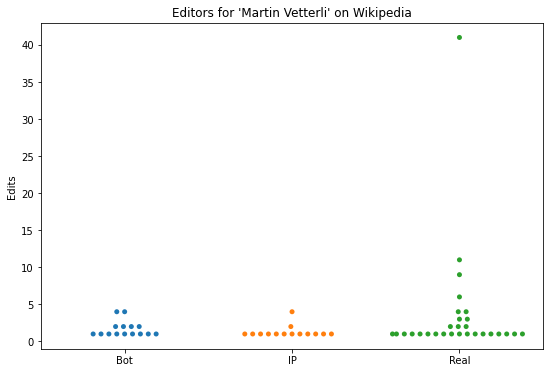

In [641]:
ueds = users(revs)
ueds["Edits"] = ueds["Minor"] + ueds["Major"]

ax = sns.swarmplot(x=ueds.index.get_level_values(0), y="Edits", data=ueds)
ax.set_title("Editors for 'Martin Vetterli' on Wikipedia")
ax.figure.set_size_inches((9, 6))
    
ax.figure.savefig(os.path.join(im_path, "edits.png"))

In [333]:
def mass_users(pages):
    # We'll want to get the bulk of the data out in the future
    
    temp = []
    
    for p in pages:
        curr = list(p.revisions(reverse=True, content=False))
        udata = users(curr)
        udata[p.title()] = udata["Minor"] + udata["Major"]
        temp.append(udata[p.title()])
    
    return pd.concat(temp, axis=1)

In [342]:
udata = mass_users(epfl_pages[:100])
udata

Gebregziabher Gebremariam  GMD SW1200MG  Kava  Pascal Lamy  \
Bot  .anacondabot                        NaN           NaN   NaN          NaN   
     28bot                               NaN           NaN   NaN          NaN   
     718 Bot                             NaN           NaN   NaN          NaN   
     A4bot                               NaN           NaN   NaN          1.0   
     AMbot                               NaN           NaN   NaN          1.0   
...                                      ...           ...   ...          ...   
Real 辩明君                                 NaN           NaN   NaN          NaN   
     达伟                                  NaN           NaN   1.0          NaN   
     隼鷹                                  NaN           NaN   NaN          NaN   
     망고소녀                                NaN           NaN   NaN          NaN   
     어거스틴                                NaN           NaN   NaN          NaN   

                   Cantonal and University Library of Lausanne  \
Bot  .anacondabot                                          NaN   
     28bot                                                 NaN   
     718 Bot                                               NaN   
     A4bot                                                 NaN   
     AMbot                                                 NaN   
...                                                        ...   
Real 辩明君                                                   NaN   
     达伟                                                    NaN   
     隼鷹                                                    NaN   
     망고소녀                                                  NaN   
     어거스틴                                                  NaN   

                   Two-wheel tractor  University of Klagenfurt  \
Bot  .anacondabot                NaN                       NaN   
     28bot                       NaN                       NaN   
     718 Bot                     NaN                       NaN   
     A4bot                       NaN                       NaN   
     AMbot                       NaN                       NaN   
...                              ...                       ...   
Real 辩明君                         NaN                       NaN   
     达伟                          NaN                       NaN   
     隼鷹                          NaN                       NaN   
     망고소녀                        NaN                       NaN   
     어거스틴                        NaN                       NaN   

                   List of universities and higher education colleges in London  \
Bot  .anacondabot                                                NaN              
     28bot                                                       NaN              
     718 Bot                                                     NaN              
     A4bot                                                       NaN              
     AMbot                                                       NaN              
...                                                              ...              
Real 辩明君                                                         NaN              
     达伟                                                          NaN              
     隼鷹                                                          NaN              
     망고소녀                                                        NaN              
     어거스틴                                                        NaN              

                   History of YouTube  Deaths in February 2014  ...  \
Bot  .anacondabot                 NaN                      NaN  ...   
     28bot                        NaN                      NaN  ...   
     718 Bot                      NaN                      NaN  ...   
     A4bot                        NaN                      NaN  ...   
     AMbot                        NaN                      NaN  ...   
...                               ...

In [343]:
usr_sum = udata.sum(axis=1)
usr_sum

Bot   .anacondabot    3.0
      28bot           3.0
      718 Bot         2.0
      A4bot           2.0
      AMbot           2.0
                     ... 
Real  辩明君             1.0
      达伟              1.0
      隼鷹              1.0
      망고소녀            1.0
      어거스틴            1.0
Length: 46561, dtype: float64

In [344]:
usr_cnt = udata.count(axis=1)
usr_cnt

Bot   .anacondabot    3
      28bot           3
      718 Bot         2
      A4bot           2
      AMbot           2
                     ..
Real  辩明君             1
      达伟              1
      隼鷹              1
      망고소녀            1
      어거스틴            1
Length: 46561, dtype: int64

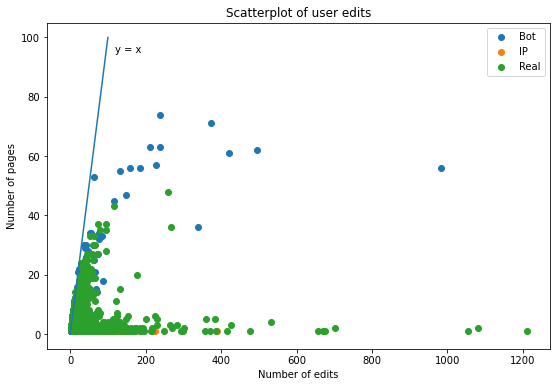

In [398]:
fig, ax = plt.subplots()
ax.set_title("Scatterplot of user edits")
ax.set_xlabel("Number of edits")
ax.set_ylabel("Number of pages")
x_vals = np.linspace(0, 100)
ax.plot(x_vals, x_vals)
ax.annotate("y = x", (120, 95))
fig.set_size_inches((9, 6))
artists = []
plot_names = []
for (ns, s), (nc, c) in zip(usr_sum.groupby(level=0), usr_cnt.groupby(level=0)):
    artists.append(plt.scatter(s, c))
    plot_names.append(ns)
ax.legend(artists, plot_names)
ax.figure.savefig(os.path.join(im_path, "users.png"))

In [373]:
for (ns, s), (nc, c) in zip(usr_sum.groupby(level=0), usr_cnt.groupby(level=0)):
    print(s)

Bot  .anacondabot     3.0
     28bot            3.0
     718 Bot          2.0
     A4bot            2.0
     AMbot            2.0
                     ... 
     Zorrobot         8.0
     Zwobot           4.0
     Zxabot           1.0
     ZéroBot         34.0
     タチコマ robot       2.0
Length: 301, dtype: float64
IP  1.122.205.50     2.0
    1.125.111.146    3.0
    1.126.105.116    1.0
    1.127.105.155    1.0
    1.129.97.101     1.0
                    ... 
    99.92.186.177    1.0
    99.92.251.167    1.0
    99.93.5.90       1.0
    99.96.146.195    2.0
    99.96.36.119     1.0
Length: 27034, dtype: float64
Real                       7.0
      !Darkfire!6'28'14    1.0
      "MyOfficial"         1.0
      $cieno $itter        1.0
      $yD!                 1.0
                          ... 
      辩明君                  1.0
      达伟                   1.0
      隼鷹                   1.0
      망고소녀                 1.0
      어거스틴                 1.0
Length: 19226, dtype: float64


# WORK IN PROGRESS

need to make a record of what pages have indeed mentions or not so we can refer to it

In [29]:
def saveData(page):
    ret = getPageScore(page)
    
    if ret is None:
        return None, None
    
    idx = page.data_item().title()
    ret.to_pickle(os.path.join("pickles", idx))
    return idx, ret

def loadData(idx):
    return pd.read_pickle(os.path.join("pickles", idx))

In [30]:
'''

fns = os.listdir("pickles")
for p in epfl_pages:
    try:
        if p.data_item().title() not in fns:
            saveData(p)
            print(p)
    except:
        pass
'''

'\n\nfns = os.listdir("pickles")\nfor p in epfl_pages:\n    try:\n        if p.data_item().title() not in fns:\n            saveData(p)\n            print(p)\n    except:\n        pass\n'

[[en:Whistleblower]]
WARNING: API warning (result): This result was truncated because it would otherwise be larger than the limit of 12,582,912 bytes.

In [31]:
banane = pwb.Page(wiki_site, u"Fréquence Banane")
banane_s = getPageScore(banane)

In [32]:
banane.data_item().title()

'Q3090425'

In [33]:
banane_s.to_pickle(banane.data_item().title())

In [34]:
pd.read_pickle(banane.data_item().title())

,Views,Size,Mentions,Score
2016-01-16,53,1242.0,0.0,0.000000
2016-01-17,8,1275.0,0.0,0.000000
2016-01-18,1,1275.0,0.0,0.000000
2016-01-19,7,1275.0,0.0,0.000000
2016-01-20,11,1307.0,0.0,0.000000
...,...,...,...,...
2020-12-18,3,1336.0,1.0,0.002246
2020-12-19,1,1336.0,1.0,0.000749
2020-12-20,2,1336.0,1.0,0.001497
2020-12-21,3,1336.0,1.0,0.002246


In [35]:
saveData(banane)

('Q3090425',
             Views    Size  Mentions     Score
 2016-01-16     53  1242.0       0.0  0.000000
 2016-01-17      8  1275.0       0.0  0.000000
 2016-01-18      1  1275.0       0.0  0.000000
 2016-01-19      7  1275.0       0.0  0.000000
 2016-01-20     11  1307.0       0.0  0.000000
 ...           ...     ...       ...       ...
 2020-12-18      3  1336.0       1.0  0.002246
 2020-12-19      1  1336.0       1.0  0.000749
 2020-12-20      2  1336.0       1.0  0.001497
 2020-12-21      3  1336.0       1.0  0.002246
 2020-12-22      2  1336.0       1.0  0.001497
 
 [1572 rows x 4 columns])

In [36]:
loadData("Q3090425")

,Views,Size,Mentions,Score
2016-01-16,53,1242.0,0.0,0.000000
2016-01-17,8,1275.0,0.0,0.000000
2016-01-18,1,1275.0,0.0,0.000000
2016-01-19,7,1275.0,0.0,0.000000
2016-01-20,11,1307.0,0.0,0.000000
...,...,...,...,...
2020-12-18,3,1336.0,1.0,0.002246
2020-12-19,1,1336.0,1.0,0.000749
2020-12-20,2,1336.0,1.0,0.001497
2020-12-21,3,1336.0,1.0,0.002246


In [37]:
a = testdata[0]
b = testdata[1]
pd.concat([a, b], axis=1, keys=["u", "v"]).fillna(0).sum(axis=1, level=1)

NameError: name 'testdata' is not defined

In [ ]:
fns = [n for n in os.listdir("pickles") if n[0] == "Q"]
testdata = [loadData(fn) for fn in fns]

init = testdata[0]

for td in testdata[1:]:
    init = pd.concat([init, td], axis=1, keys=["l", "r"]).fillna(0).sum(axis=1, level=1)
    
init.plot()

In [ ]:
init["Views"].plot()

In [ ]:
init["Mentions"].plot()

In [ ]:
init["Score"].plot()

## Combining Data

In [ ]:
cl = pd.DataFrame(columns=["views", "mentions", "edits"])
cl.loc[495998] = [1, 2, 4]
cl

In [ ]:
for i, p in enumerate(epfl_pages[:10]):
    print(i)
    getPageScore(p)

## Editors

In [ ]:
for uid, dat in df.groupby("userid"):
    print(uid)
    for val, x in dat.groupby("minor"):
        print(val, sum(x["diff"]))

entry over time
* list of incoming links
* list of outgoing links
* mention history

work with user pages  
potentially use the wikipedia package for smaller operations as it seems to be faster, maybe do some timed tests

count improve counts by checking revisions 5 before and 5 after to ignore edit wars and such

Will need to handle the problem or redirects and page name changes in the future.

Will need to classify whether we found the subject through keywords or if EPFL was mentioned.

We assume mentions are only added for performance and simplicity reasons. It's very rare that content will be removed from pages.

Link pages with contributors

Update data over time instead of recomputing everything

Bot that changes names of EPFL or makes a suggestion on the talk page

orcid, unique identifier for papers

https://go.epfl.ch/wikiproject

correlate growth of epfl mentions and wikipedia in general (or science related pages, lets see what we can do)

In [562]:
[r["size"] for r in revs][-5:]

[2614, 2634, 2612, 2667, 2679]

In [668]:
talkpage = pwb.Page(wiki_site, u"Talk:Martin Vetterli")
talkpage

Page('Talk:Martin Vetterli')

In [672]:
list(talkpage.categories())

[Category('Category:Automatically assessed biography articles'),
 Category('Category:Biography articles of living people'),
 Category('Category:Low-importance Switzerland articles'),
 Category('Category:Noindexed pages'),
 Category('Category:Stub-Class Switzerland articles'),
 Category('Category:Stub-Class biography articles'),
 Category('Category:WikiProject Biography articles')]

In [674]:
cats = list(page.categories())

In [678]:
cats[0].categoryinfo

{'size': 13440, 'pages': 13440, 'files': 0, 'subcats': 0}

In [679]:
# Function that checks that the category records are correct (if a page has been removed from a category, it will put it in the legacy records instead)
def sanitizeCategories():
    pass

In [791]:
epfl_pages[:100]

[Page('Bubacarr Bah'),
 Page('Maria Belgica of Portugal'),
 Page('Electric clock'),
 Page('Timeline of the COVID-19 pandemic in Russia'),
 Page('Chibok schoolgirls kidnapping'),
 Page("European Citizens' Initiative"),
 Page('Schulich School of Law'),
 Page('Sports in New York (state)'),
 Page('Elderly care'),
 Page('Raffaella Buonsanti'),
 Page('Denice Denton'),
 Page('Easter Monday'),
 Page('Cannabis (drug)'),
 Page('Arts et Métiers ParisTech'),
 Page('History of Digital Equipment Corporation'),
 Page('List of Greek Americans'),
 Page('List of forestry universities and colleges'),
 Page('Cognex Corporation'),
 Page('Safety of electronic cigarettes'),
 Page('Global Educational Network for Satellite Operations'),
 Page('David E. Cane'),
 Page('Fred Brooks'),
 Page('Aafia Siddiqui'),
 Page('Sacramento, California'),
 Page('Claudia R. Binder'),
 Page('Far Eastern State University of Humanities'),
 Page('RM-ODP'),
 Page('Shale oil extraction'),
 Page('Foreign relations of Austria'),
 Page(

In [142]:
def extlink_data(page):
    links = [link.split("/", 5)[-1] if "web.archive.org" in link else link for link in page.extlinks()]
    domains = pd.DataFrame([tldextract.extract(link) for link in links], columns=["subdomain", "domain", "suffix"])
    
    try:
        domains["tld"] = domains["suffix"].str.split(".", expand=False).apply(lambda e : e[-1])
        domains["site"] = domains["domain"] + "." + domains["suffix"]
    except:
        pass

    sites = domains["site"].value_counts()
    tlds = domains["tld"].value_counts()
    return page.title(), sites, tlds

In [143]:
titles, sites, tlds = extlink_data(page)
tlds

org     16
ch      13
fr       3
com      2
edu      2
jp       2
info     1
gov      1
cz       1
il       1
no       1
nl       1
Name: tld, dtype: int64

In [129]:
sites

epfl.ch                              5
snf.ch                               5
acm.org                              2
bnf.fr                               2
mathgenealogy.org                    1
loc.gov                              1
waveletsandsubbandcoding.org         1
nkp.cz                               1
nii.ac.jp                            1
foundationsofsignalprocessing.org    1
wikidata.org                         1
unil.ch                              1
mics.org                             1
idref.fr                             1
sp4comm.org                          1
orcid.org                            1
worldcat.org                         1
researcherid.com                     1
nae.edu                              1
nli.org.il                           1
bibsys.no                            1
swtr.ch                              1
coursera.org                         1
admin.ch                             1
dblp.org                             1
viaf.org                 

In [259]:
temp = epfl_pages[:500]

series = np.array([extlink_data(t) for t in temp], dtype=object).transpose()

In [152]:
pd.concat([pd.DataFrame(s, name=t) for t, s in tuple(series[0:2])])

ValueError: too many values to unpack (expected 2)

In [260]:
refs = pd.concat(series[1], axis=1, keys=series[0])
refs

,Gebregziabher Gebremariam,GMD SW1200MG,Kava,Pascal Lamy,Cantonal and University Library of Lausanne,Two-wheel tractor,University of Klagenfurt,List of universities and higher education colleges in London,History of YouTube,Deaths in February 2014,...,History of feminism,Vehicle emissions control,Democracy,Colombia–United States relations,Diving cylinder,Florian Müller-Plathe,Phases of Operation Car Wash,CFC,Juan Rivero Torres,Reymond Clavel
iaaf.org,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ingnycmarathon.org,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
facebook.com,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
worldathletics.org,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bbc.co.uk,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,9.0,...,1.0,1.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
global-regulation.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
blogdoeliomar.com.br,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
globalhealthrights.org,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
globalnegotiator.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


In [273]:
ref_sum = refs.sum(axis=1)
ref_sum[ref_sum > 600]

bbc.co.uk               626.0
google.com             2265.0
nih.gov                1525.0
doi.org                2438.0
semanticscholar.org     679.0
worldcat.org            906.0
nytimes.com            1210.0
archive.org             850.0
theguardian.com         614.0
dtype: float64

In [262]:
ref_cnt = refs.count(axis=1)
ref_cnt

iaaf.org                    6
ingnycmarathon.org          1
facebook.com               17
worldathletics.org          5
bbc.co.uk                 135
                         ... 
global-regulation.com       1
blogdoeliomar.com.br        1
globalhealthrights.org      1
globalnegotiator.com        1
parallemic.org              1
Length: 12804, dtype: int64

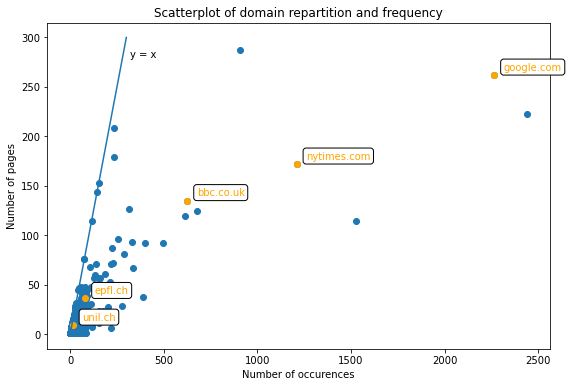

In [400]:
ax = plt.scatter(ref_sum, ref_cnt).axes
ax.set_title("Scatterplot of domain repartition and frequency")
ax.set_xlabel("Number of occurences")
ax.set_ylabel("Number of pages")
fig = plt.gcf()
fig.set_size_inches((9, 6))
x_vals = np.linspace(0, 300)
ax.plot(x_vals, x_vals)
ax.annotate("y = x", (320, 280))
for t in ["epfl.ch", "unil.ch", "bbc.co.uk", "google.com", "nytimes.com"]:
    ax.scatter(ref_sum[t], ref_cnt[t], color="orange")
    ax.annotate(t, (ref_sum[t]+50, ref_cnt[t]+5), color="orange", bbox=dict(facecolor='white', boxstyle="round,pad=0.3"))
ax.figure.savefig(os.path.join(im_path, "domains.png"))

In [264]:
refs_tld = pd.concat(series[2], axis=1, keys=series[0])
refs_tld

,Gebregziabher Gebremariam,GMD SW1200MG,Kava,Pascal Lamy,Cantonal and University Library of Lausanne,Two-wheel tractor,University of Klagenfurt,List of universities and higher education colleges in London,History of YouTube,Deaths in February 2014,...,History of feminism,Vehicle emissions control,Democracy,Colombia–United States relations,Diving cylinder,Florian Müller-Plathe,Phases of Operation Car Wash,CFC,Juan Rivero Torres,Reymond Clavel
org,17.0,1.0,106.0,21.0,6.0,9.0,5.0,2.0,5.0,31.0,...,93.0,5.0,94.0,37.0,23.0,4.0,4.0,NaN,NaN,5.0
com,2.0,5.0,16.0,4.0,3.0,21.0,10.0,7.0,119.0,377.0,...,29.0,9.0,55.0,19.0,58.0,5.0,107.0,NaN,2.0,NaN
uk,1.0,NaN,1.0,NaN,NaN,1.0,NaN,11.0,14.0,59.0,...,13.0,1.0,26.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN
cn,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ca,NaN,1.0,4.0,1.0,NaN,NaN,NaN,NaN,NaN,2.0,...,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mobi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
to,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
city,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [265]:
ref_tld_sum = refs_tld.sum(axis=1)
ref_tld_sum

org      12875.0
com      21271.0
uk        2498.0
cn         155.0
ca         688.0
          ...   
tj           1.0
mobi         2.0
to           3.0
city         1.0
solar        1.0
Length: 205, dtype: float64

In [266]:
ref_tld_cnt = refs_tld.count(axis=1)
ref_tld_cnt

org      464
com      450
uk       265
cn        38
ca       132
        ... 
tj         1
mobi       1
to         2
city       1
solar      1
Length: 205, dtype: int64

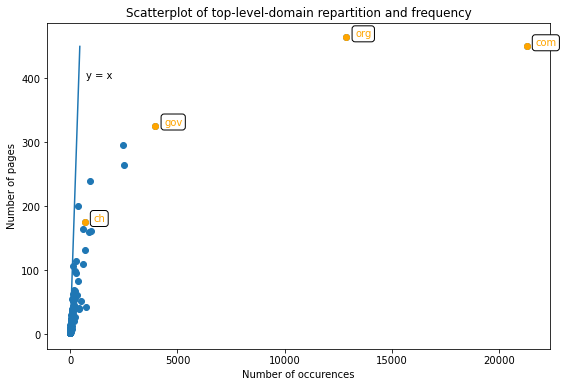

In [399]:
ax = plt.scatter(ref_tld_sum, ref_tld_cnt).axes
ax.set_title("Scatterplot of top-level-domain repartition and frequency")
ax.set_xlabel("Number of occurences")
ax.set_ylabel("Number of pages")
fig = plt.gcf()
fig.set_size_inches((9, 6))
x_vals = np.linspace(0, 450)
ax.plot(x_vals, x_vals)
ax.annotate("y = x", (720, 400))
for t in ["ch", "org", "com", "gov"]:
    ax.scatter(ref_tld_sum[t], ref_tld_cnt[t], color="orange")
    ax.annotate(t, (ref_tld_sum[t]+400, ref_tld_cnt[t]+1), color="orange", bbox=dict(facecolor='white', boxstyle="round,pad=0.3"))
ax.figure.savefig(os.path.join(im_path, "tlds.png"))

In [840]:
import sys
temp = pd.concat(series[2], axis=1, keys=series[0])
sys.getsizeof(temp)

85114

In [847]:
temp2 = temp.astype(pd.SparseDtype("int", np.nan))
sys.getsizeof(temp2)

16186

In [906]:
pszs = [getPageSize(p) for p in epfl_pages[:10]]

In [910]:
df = pd.concat(pszs, axis=1)
print(sys.getsizeof(df))

print(sys.getsizeof(df.astype(pd.SparseDtype("int", np.nan))))

17792
10128


# Page sizes

In [25]:
# Need to make page to item and item to page functions
# Heavily bottlenecked by the `revisions` function unfortunately

# Gets given keys of all revisions after a given timestamp
def getRevisionsTags(page, ts, keys, content=False):
    gen = page.revisions(reverse=True, content=content)
    
    while True:
        try:
            v = next(gen)
            t = v["timestamp"]
            
            if ts is None or t > ts:
                yield t, [v[key] for key in keys]
            else:
                return
        except StopIteration:
            return

def updatePageSizes(pagecodes, rescan=False):
    path = os.path.join("pickles", "en_page_sizes.pkl")
    
    try:
        prev = pd.read_pickle(path)
    except:
        prev = pd.DataFrame()
        
    dfs = [prev]
    
    if rescan:
        pagecodes += list(prev.columns)
    
    for code in tqdm(pagecodes):
        try:
            # Recover page from code
            p = pwb.Page(wiki_site, pwb.ItemPage(repo, code).sitelinks["enwiki"].ns_title())
        except:
            continue

        # Set limit timestamp (or None if no data yet)
        ts = prev[code].last_valid_index() if code in prev.columns else None
        
        # Get values after that timestamp
        values = [(t, v[0]) for t, v in getRevisionsTags(p, ts, ["size"])]
        
        if len(values):
            # Sample every month and shift by 1 day to get 1st of month
            df = pd.DataFrame(values, columns=[0, code]).set_index(0)
            df = df.groupby(pd.Grouper(freq="1M")).nth(-1).resample("1M").pad()
            df.index = df.index.shift(1, freq="D")
            
            # Combine with old data if it exists
            if code in prev.columns:
                df = df.combine_first(prev[code])
                

            dfs.append(df)
    
    curr = pd.concat(dfs, axis=1)
    curr = curr.ffill(axis=0)
    curr.to_pickle(path)
    
    return curr

In [26]:
pcodes = [p.data_item().title() for p in epfl_pages[:300]]
pszs = updatePageSizes(pcodes)

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [29:50<00:00,  5.97s/it]


In [60]:
pszs

,Q62512191,Q3290884,Q2607895,Q96409910,Q16725863,Q52857,Q7432967,Q7579890,Q437458,Q88160407,...,Q76727,Q1587576,Q696577,Q932402,Q4813188,Q152171,Q29552,Q60045,Q280971,Q3489621
0,,,,,,,,,,,,,,,,,,,,,
2001-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1220.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-01,9681.0,3628.0,20622.0,189738.0,78375.0,43170.0,48355.0,27017.0,44926.0,15049.0,...,47976.0,2718.0,43128.0,3109.0,13421.0,46443.0,226603.0,67919.0,3680.0,111405.0
2020-11-01,9681.0,3628.0,20622.0,189769.0,79299.0,43394.0,48331.0,28075.0,44926.0,15005.0,...,47976.0,2718.0,43128.0,3109.0,13416.0,46493.0,257526.0,67947.0,3680.0,111351.0
2020-12-01,9681.0,3628.0,20569.0,189769.0,79319.0,44067.0,48331.0,31449.0,44856.0,14493.0,...,47981.0,2718.0,60806.0,3109.0,13416.0,46712.0,265472.0,67999.0,3680.0,111281.0


In [86]:
total_size = pszs.sum(axis=1)
total_size.index.name = "Date"
total_size.name = "Select Pages Size"
total_size

Date
2001-03-01         143.0
2001-04-01         309.0
2001-05-01        5634.0
2001-06-01       10074.0
2001-07-01       11294.0
                 ...    
2020-10-01    27160082.0
2020-11-01    27274369.0
2020-12-01    27537027.0
2021-01-01    27731340.0
2021-02-01    27736231.0
Freq: MS, Name: Select Pages Size, Length: 240, dtype: float64

<AxesSubplot:xlabel='Date'>

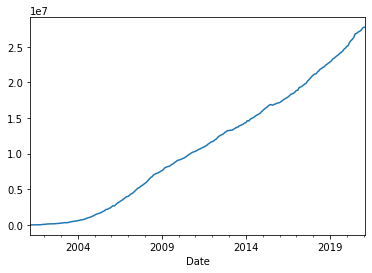

In [72]:
total_size.plot()

# Page count

Here we look at how many of our pages exist at a given time

In [96]:
def pageCounts(df):
    ret = df.count(axis=1)
    ret.index.name = "Date"
    ret.name = "Select Pages Count"
    return ret

In [97]:
pcnts = pageCounts(pszs)
pcnts

Date
2001-03-01      1
2001-04-01      2
2001-05-01      4
2001-06-01      6
2001-07-01      7
             ... 
2020-10-01    439
2020-11-01    440
2020-12-01    441
2021-01-01    442
2021-02-01    442
Freq: MS, Name: Select Pages Count, Length: 240, dtype: int64

<AxesSubplot:xlabel='Date'>

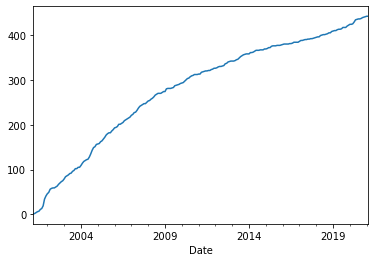

In [67]:
pcnts.plot()

# Page size and page counts ratio

<AxesSubplot:xlabel='Date'>

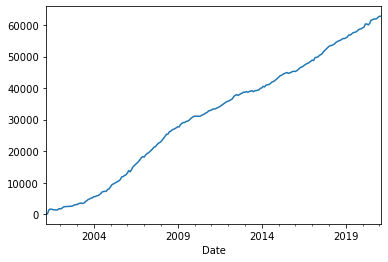

In [68]:
(total_size / pcnts).plot()

In [34]:
def loadWikistats(fn, name, exp=0):
    path = os.path.join("csv", "wikistats", fn)
    
    with open(path, "rb") as f:
        df = pd.read_csv(f)
        
    df.index = pd.to_datetime(df["month"], format="%Y-%m-%dT%H:%M:%S.%fZ").rename("Date")
    df = df["total.total"].rename(name) * 10**exp
        
    return df

In [84]:
wiki_size = loadWikistats("size_change_en.csv", name="English Wikipedia Size", exp=0)
wiki_size = wiki_size[17:].cumsum()
wiki_size

Date
2002-06-01        -9047814
2002-07-01        -5506300
2002-08-01         2751399
2002-09-01        19660466
2002-10-01       100571558
                  ...     
2020-07-01    137741611176
2020-08-01    138606511071
2020-09-01    139394891531
2020-10-01    140241416864
2020-11-01    141143046895
Name: English Wikipedia Size, Length: 222, dtype: int64

In [85]:
wiki_cnts = loadWikistats("pages_en.csv", name="English Wikipedia Count", exp=0)
wiki_cnts

Date
2001-01-01          60
2001-02-01         216
2001-03-01         728
2001-04-01        1338
2001-05-01        2624
                ...   
2020-07-01    39470296
2020-08-01    39876317
2020-09-01    40090855
2020-10-01    40287846
2020-11-01    40472745
Name: English Wikipedia Count, Length: 239, dtype: int64

Date
2002-06-01    -220.947839
2002-07-01    -123.957137
2002-08-01      54.645462
2002-09-01     318.997696
2002-10-01     990.433196
                 ...     
2020-07-01    3489.753692
2020-08-01    3475.910553
2020-09-01    3476.974775
2020-10-01    3480.985726
2020-11-01    3487.360368
Freq: MS, Name: English Wikipedia Ratio, Length: 222, dtype: float64

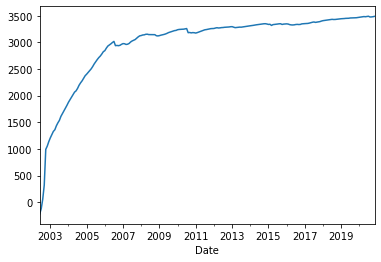

In [124]:
wiki_ratio = pd.concat([wiki_size, wiki_cnts], axis=1).dropna()
wiki_ratio = wiki_ratio.iloc[:,0] / wiki_ratio.iloc[:,1]
wiki_ratio.name = "English Wikipedia Ratio"
wiki_ratio.plot()
wiki_ratio

Date
2001-03-01      143.000000
2001-04-01      154.500000
2001-05-01     1408.500000
2001-06-01     1679.000000
2001-07-01     1613.428571
                  ...     
2020-10-01    61868.068337
2020-11-01    61987.202273
2020-12-01    62442.238095
2021-01-01    62740.588235
2021-02-01    62751.653846
Freq: MS, Name: Select Pages Ratio, Length: 240, dtype: float64

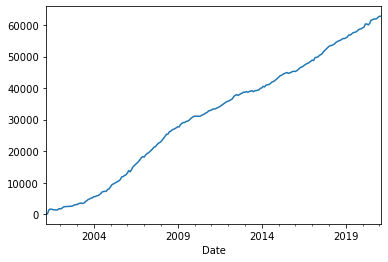

In [115]:
pages_ratio = pd.concat([total_size, pcnts], axis=1).dropna()
pages_ratio = pages_ratio.iloc[:,0] / pages_ratio.iloc[:,1]
pages_ratio.name = "Select Pages Ratio"
pages_ratio.plot()
pages_ratio

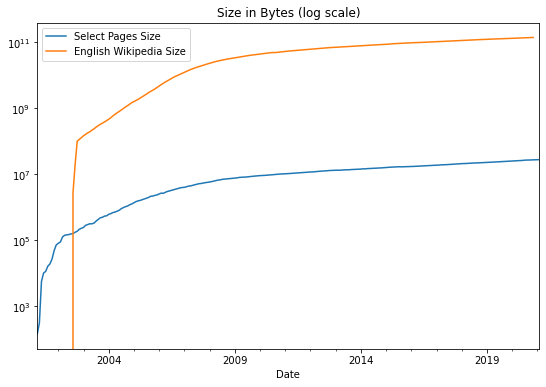

In [99]:
ax = pd.concat([total_size, wiki_size], axis=1).plot(logy=True, figsize=(9, 6))
ax.set_title("Size in Bytes (log scale)")
ax.figure.savefig(os.path.join(im_path, "size_comp.png"))

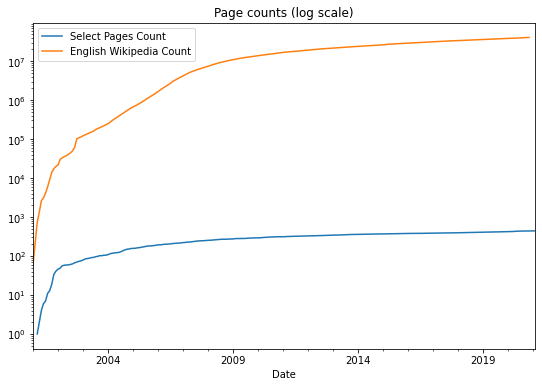

In [98]:
ax = pd.concat([pcnts, wiki_cnts], axis=1).plot(logy=True, figsize=(9, 6))
ax.set_title("Page counts (log scale)")
ax.figure.savefig(os.path.join(im_path, "count_comp.png"))

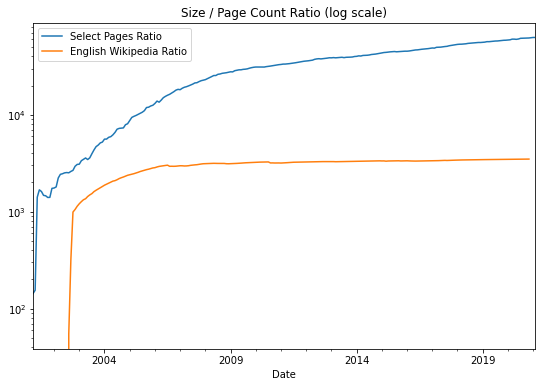

In [126]:
ax = pd.concat([pages_ratio, wiki_ratio], axis=1).plot(logy=True, figsize=(9, 6))
ax.set_title("Size / Page Count Ratio (log scale)")
ax.figure.savefig(os.path.join(im_path, "ratio_comp.png"))

# Performance comparison

In [1277]:
import time
start = time.time()
page.revisions()
end = time.time()
print(end-start)

0.6295251846313477


In [1264]:
print(epfl_pages[100].title())

Dallas


In [1285]:
# Can only run on one page at a time
start = time.time()
revs = next(iter(api.PropertyGenerator('revisions', site=wiki_site, parameters={
    'titles': 'Martin Vetterli',
    'rvprop': 'timestamp|size',
})))['revisions']
end = time.time()
print(end-start)

APIError: invalidparammix: "titles", "pageids" or a generator was used to supply multiple pages, but the "rvlimit", "rvstartid", "rvendid", "rvdir=newer", "rvuser", "rvexcludeuser", "rvstart", and "rvend" parameters may only be used on a single page.
[help: See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/mailman/listinfo/mediawiki-api-announce&gt; for notice of API deprecations and breaking changes.]

In [1284]:
revs

[{'timestamp': '2020-12-29T18:59:19Z', 'size': 11843},
 {'timestamp': '2020-11-02T18:46:37Z', 'size': 11843},
 {'timestamp': '2020-09-25T17:28:20Z', 'size': 11895},
 {'timestamp': '2020-08-22T16:50:53Z', 'size': 11896},
 {'timestamp': '2020-08-14T17:33:22Z', 'size': 11897},
 {'timestamp': '2020-07-02T22:33:23Z', 'size': 11839},
 {'timestamp': '2020-07-02T21:08:29Z', 'size': 11647},
 {'timestamp': '2020-03-27T10:21:31Z', 'size': 11634},
 {'timestamp': '2019-09-25T23:41:07Z', 'size': 11402},
 {'timestamp': '2018-01-17T13:21:25Z', 'size': 11398},
 {'timestamp': '2017-09-04T14:53:32Z', 'size': 11174},
 {'timestamp': '2017-08-25T15:46:37Z', 'size': 11173},
 {'timestamp': '2017-08-06T12:45:53Z', 'size': 11202},
 {'timestamp': '2017-07-23T02:17:45Z', 'size': 11172},
 {'timestamp': '2017-07-21T22:47:35Z', 'size': 11198},
 {'timestamp': '2017-07-11T19:10:58Z', 'size': 11124},
 {'timestamp': '2017-06-13T14:45:36Z', 'size': 11124},
 {'timestamp': '2017-06-13T07:52:41Z', 'size': 11161},
 {'timesta

In [ ]:
# Paralllelize queries to the API